In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# 대화기록 요약 추가 

- 대화 기록 유지, 지속성 
    - 대화를 지속하기 쉽게 만들어줌 
    - 하지만 대화가 길어질수록 대화 기록이 누적되어 `context window`를 더 많이 차지하게 됨
    - `LLM` 호출이 더 비싸고 길어지며, 잠재적으로 오류가 발생할 수 있어 바람직하지 않을 수 있음 
    - 이를 해결하기 위한 한 가지 방법은 현재까지의 대화 요약본을 생성하고, 이를 최근 `N` 개의 메시지와 함께 사용하는 것 

- 프로세스
    - 대화가 너무 긴지 확인 (메시지 수나 메시지 길이로 확인 가능)
    - 너무 길다면 요약본 생성 (이를 위한 프롬프트 필요)
    - 마지막 `N` 개의 메시지를 제외한 나머지 삭제 (`DeleteMessage`)

In [6]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages

In [ ]:
# 메모리 저장소 설정
memory = MemorySaver()


# 메시지 상태와 요약 정보를 포함하는 상태 클래스
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str


# 모델 초기화
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [5]:
def ask_llm(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 시스템 메시지로 추가
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    # 모델 호출
    response = model.invoke(messages)

    return {"messages": [response]}

In [ ]:
# 대화 종료 또는 요약 결정 로직
# Literal : 값의 범위를 제한하고 의도를 명확히 표현할 수 있게 해두는 도구 (Type Hint) 
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    # 메시지 목록 확인
    messages = state["messages"]

    # 메시지 수가 6개 초과라면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"
    return END

In [8]:
# 대화 내용 요약 및 메시지 정리 로직
def summarize_conversation(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 요약 메시지 생성
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above in Korean:"
        )
    else:
        # 요약 메시지 생성
        summary_message = "Create a summary of the conversation above in Korean:"


    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    
    return {"summary": response.content, "messages": delete_messages}

In [9]:
# GRAPH
workflow = StateGraph(State)

workflow.add_node("conversation", ask_llm)
workflow.add_node(summarize_conversation)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
)
workflow.add_edge("summarize_conversation", END)

app = workflow.compile(checkpointer=memory)

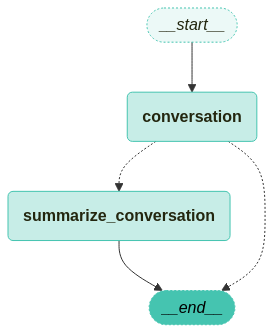

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

**그래프 해석**

- 기본 대화는 항상 `conversation`에서 시작
- 요약이 필요한 조건일 때만 `summarize_conversation` 실행
- 모든 흐름은 결국 `__end__`로 종료됨

In [11]:
# 업데이트 정보 출력 함수
def print_update(update):
    # 업데이트 딕셔너리 순회
    for k, v in update.items():
        # 메시지 목록 출력
        for m in v["messages"]:
            m.pretty_print()
        # 요약 정보 존재 시 출력
        if "summary" in v:
            print(v["summary"])

In [12]:
# 설정 
config = {"configurable": {"thread_id": "001"}}

# 첫 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="안녕하세요? 반갑습니다. 제 이름은 김철수 입니다.")
input_message.pretty_print()

# 스트림 모드에서 첫 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 두 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 이름이 뭔지 기억하세요?")
input_message.pretty_print()

# 스트림 모드에서 두 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 세 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 직업은 AI 엔지니어 입니다.")
input_message.pretty_print()

# 스트림 모드에서 세 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕하세요? 반갑습니다. 제 이름은 김철수 입니다.
================================== Ai Message ==================================

안녕하세요, 김철수님! 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

제 이름이 뭔지 기억하세요?
================================== Ai Message ==================================

네, 김철수님이라고 하셨습니다. 다른 질문이나 이야기하고 싶은 내용이 있으신가요?
================================ Human Message =================================

제 직업은 AI 엔지니어 입니다.
================================== Ai Message ==================================

멋진 직업이네요, 김철수님! AI 엔지니어로서 어떤 분야에 주로 집중하고 계신가요? 또는 어떤 프로젝트에 참여하고 계신지 궁금합니다.


In [13]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='안녕하세요? 반갑습니다. 제 이름은 김철수 입니다.', additional_kwargs={}, response_metadata={}, id='ca510e0f-2254-4e93-8f39-32a1b7b62994'),
  AIMessage(content='안녕하세요, 김철수님! 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 22, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb562f5a-f084-4928-9892-bf0be2c29ba5-0', usage_metadata={'input_tokens': 22, 'output_tokens': 20, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='제 이름이 뭔지 기억하세요?', additional_kwargs={}, response_metadata={}, i

In [14]:
# 사용자 입력 메시지 객체 생성
input_message = HumanMessage(
    content="최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다."
)

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.
================================== Ai Message ==================================

LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 논문에 대해 이야기하고 싶으신가요? 아니면 LLM의 최신 동향이나 기술에 대해 궁금한 점이 있으신가요?
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


김철수님과의 대화 요약:

김철수님은 AI 엔지니어이며, 최근 LLM(대규모 언어 모델)에 대해 더 알아보고 있다고 하셨습니다. 현재 LLM에 관한 최근 논문을 읽고 계신다고 말씀하셨습니다. 대화 중에 LLM의 특정 주제나 논문에 대해 이야기하거나

In [15]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', additional_kwargs={}, response_metadata={}, id='8fd6555c-4bdf-4b4b-974c-d0b490fb9002'),
  AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 논문에 대해 이야기하고 싶으신가요? 아니면 LLM의 최신 동향이나 기술에 대해 궁금한 점이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 178, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c3558cb-3e0c-48de-ab2c-787a83a408ad-0', usage_metadata={'input_tokens': 178, 'output_tokens': 80, 'total_tokens': 258, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [16]:
messages = values["messages"]
messages

[HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', additional_kwargs={}, response_metadata={}, id='8fd6555c-4bdf-4b4b-974c-d0b490fb9002'),
 AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 논문에 대해 이야기하고 싶으신가요? 아니면 LLM의 최신 동향이나 기술에 대해 궁금한 점이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 178, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c3558cb-3e0c-48de-ab2c-787a83a408ad-0', usage_metadata={'input_tokens': 178, 'output_tokens': 80, 'total_tokens': 258, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

In [17]:
# 사용자 메시지 객체 생성
input_message = HumanMessage(content="제 이름이 무엇인지 기억하세요?")

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

제 이름이 무엇인지 기억하세요?
================================== Ai Message ==================================

네, 당신의 이름은 김철수님입니다. LLM에 대한 연구를 하고 계신다고 하셨죠. 더 궁금한 점이나 논의하고 싶은 주제가 있으신가요?


In [18]:
# 사용자 메시지 객체 생성
input_message = HumanMessage(content="제 직업도 혹시 기억하고 계세요?")

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

제 직업도 혹시 기억하고 계세요?
================================== Ai Message ==================================

네, 김철수님은 AI 엔지니어이십니다. LLM에 대해 더 알아보고 계신다고 하셨죠. 관련된 질문이나 논의하고 싶은 주제가 있으시면 말씀해 주세요!


-----
** End of Documents **